Modelado XGeboost

1. Importación de librerías

In [13]:
import os as os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score,  f1_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

Carga de Datos

In [14]:
df = pd.read_csv("../data/processed/online_news_modified_engineered_processed_20251010.csv")

# El dataset de UCI ya viene mayormente numérico y sin nulos.
# Variable objetivo: shares
# Definimos popularidad binaria con D1=1400:

# Quita espacios en los nombres de columnas (en UCI vienen con espacios al inicio)
df.columns = [c.strip() for c in df.columns]

# Convierte TODAS las columnas (excepto 'url') a numéricas
num_cols = [c for c in df.columns if c != "url"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Asegura que 'shares' sea numérica y sin NaN críticos
if df["shares"].isna().any():
    # Si hay filas raras, las quitamos
    df = df.dropna(subset=["shares"])

# 4) Orden temporal por 'timedelta' (también puede venir como float/str)
if "timedelta" in df.columns:
    df["timedelta"] = pd.to_numeric(df["timedelta"], errors="coerce")
    df = df.dropna(subset=["timedelta"]).sort_values("timedelta").reset_index(drop=True)
else:
    # Fallback si no existiera (raro en este dataset)
    df = df.reset_index(drop=True)

# 5) Objetivo binario (D1 = 1400, como en el paper)
D1 = 1400
df["popular"] = (df["shares"] > D1).astype(int)

# 6) Define X, y (quitando columnas no predictoras)
drop_cols = ["shares", "popular"]
if "url" in df.columns:
    drop_cols.append("url")
X = df.drop(columns=drop_cols)
y = df["popular"]



Funciones auxiliares

In [15]:
"""
    Determina el umbral de decisión (threshold) que maximiza la métrica F1 para la clase positiva (1).

    Parámetros
    ----------
    y_true : array-like
        Etiquetas verdaderas (0 = no popular, 1 = popular).
    proba : array-like
        Probabilidades predichas por el modelo (salida continua entre 0 y 1).
    grid : array-like, opcional
        Conjunto de valores de umbral que se probarán para encontrar el mejor F1.
        Por defecto, se generan 141 puntos equiespaciados entre 0.15 y 0.85.

    Retorna
    -------
    best_thr : float
        Umbral que maximiza la puntuación F1 en los datos de validación.
    """

def pick_thr_f1(y_true, proba, grid=np.linspace(0.15, 0.85, 141)):
    """Selecciona el umbral que maximiza F1 de la clase positiva"""
    best, best_thr = -1, 0.5
    for t in grid:
        pred = (proba >= t).astype(int)
        sc = f1_score(y_true, pred, pos_label=1)
        if sc > best:
            best, best_thr = sc, t
    return best_thr


In [16]:
"""
    Entrena un modelo XGBoost con los parámetros dados y evalúa su desempeño en validación y test.

    Parámetros
    ----------
    params : dict
        Diccionario con los hiperparámetros de XGBoost (ej. learning_rate, max_depth, etc.).
    dtrain : xgb.DMatrix
        Conjunto de entrenamiento.
    dvalid : xgb.DMatrix
        Conjunto de validación usado para early stopping y cálculo del threshold.
    dtest : xgb.DMatrix
        Conjunto de prueba (solo para evaluación final, sin influencia en el entrenamiento).
    nrounds : int, opcional
        Número máximo de iteraciones (boosting rounds). Por defecto 1500.
    esr : int, opcional
        Número de rondas sin mejora en validación antes de detener (early stopping). Por defecto 50.

    Retorna
    -------
    dict
        Contiene:
        - bst : modelo entrenado (Booster de XGBoost)
        - auc_valid : AUC obtenido en el conjunto de validación
        - auc_test : AUC obtenido en el conjunto de prueba
        - f1_test : F1-score en prueba, usando el threshold encontrado en validación
        - thr_from_valid : threshold óptimo obtenido en validación
        - best_iteration : número de rondas efectivas usadas antes del early stopping
    """

def train_eval(params, dtrain, dvalid, dtest, nrounds=1500, esr=50):
    """Entrena un modelo XGBoost y devuelve métricas de valid/test."""
    evals = [(dtrain, "train"), (dvalid, "valid")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=nrounds,
        early_stopping_rounds=esr,
        evals=evals,
        verbose_eval=False
    )
    
    # Predicciones
    p_val = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
    p_tst = bst.predict(dtest,  iteration_range=(0, bst.best_iteration + 1))

    # Métricas
    auc_val = roc_auc_score(y_valid, p_val)
    thr_val = pick_thr_f1(y_valid, p_val)
    auc_tst = roc_auc_score(y_test, p_tst)
    f1_tst  = f1_score(y_test, (p_tst >= thr_val).astype(int), pos_label=1)

    return {
        "bst": bst,
        "auc_valid": auc_val,
        "auc_test": auc_tst,
        "f1_test": f1_tst,
        "thr_from_valid": thr_val,
        "best_iteration": int(bst.best_iteration)
    }

In [17]:
#Separacion respetando orden temporal
n = len(df)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
X_test,  y_test  = X.iloc[valid_end:], y.iloc[valid_end:]

In [18]:
# Crear DMatrix respetando orden temporal
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest  = xgb.DMatrix(X_test,  label=y_test)

In [19]:
# Calcula el factor de balanceo entre clases (para problemas desbalanceados)
# Fórmula: scale_pos_weight = (# negativos / # positivos)
# Si el dataset tiene muchas menos muestras de la clase 1 (popular),
# este parámetro ayuda a que el modelo no la ignore.
scale_pos_weight = max(1.0, (len(y_train) - y_train.sum()) / max(1, y_train.sum()))

# Parámetros base que se mantienen fijos durante el Grid Search
# Estos definen el tipo de modelo, dispositivo y métrica de evaluación.
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",   # XGBoost 2.x compatible
    "device": "cuda",        # usa "cpu" si no tienes GPU
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
}
# Este diccionario define los valores a probar para cada hiperparámetro clave.
# La combinación de todos genera la rejilla completa (combinaciones cartesianas).
param_grid = {
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 6],
    "subsample": [0.7, 0.85],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda": [3, 7],
    "learning_rate": [0.03, 0.05, 0.08],
}
# En total, esta configuración generará:
# 3 (max_depth) × 3 (min_child_weight) × 2 (subsample) × 2 (colsample_bytree)
# × 2 (reg_lambda) × 3 (learning_rate) = 216 combinaciones posibles.

In [20]:
#Almacenar resaultados
results = []
models = []

#Revisar resultados 
for g in ParameterGrid(param_grid):
    params = base_params.copy()
    params.update(g)
    
    # Aquí pasamos DMatrix
    res = train_eval(params, dtrain, dvalid, dtest)
    
    results.append({**g, **res})
    models.append(res["bst"])

results_df = pd.DataFrame(results).sort_values(["auc_valid","auc_test"], ascending=False).reset_index(drop=True)
print(results_df.head(10))


   colsample_bytree  learning_rate  max_depth  min_child_weight  reg_lambda  \
0               0.9           0.05          6                 3           3   
1               0.9           0.05          6                 6           3   
2               0.9           0.08          4                 1           7   
3               0.9           0.05          4                 3           7   
4               0.9           0.05          6                 1           3   
5               0.9           0.05          6                 6           3   
6               0.9           0.05          4                 6           7   
7               0.9           0.05          6                 3           7   
8               0.7           0.05          4                 1           3   
9               0.9           0.03          8                 3           7   

   subsample                                              bst  auc_valid  \
0       0.70  <xgboost.core.Booster object at 0x7451a1

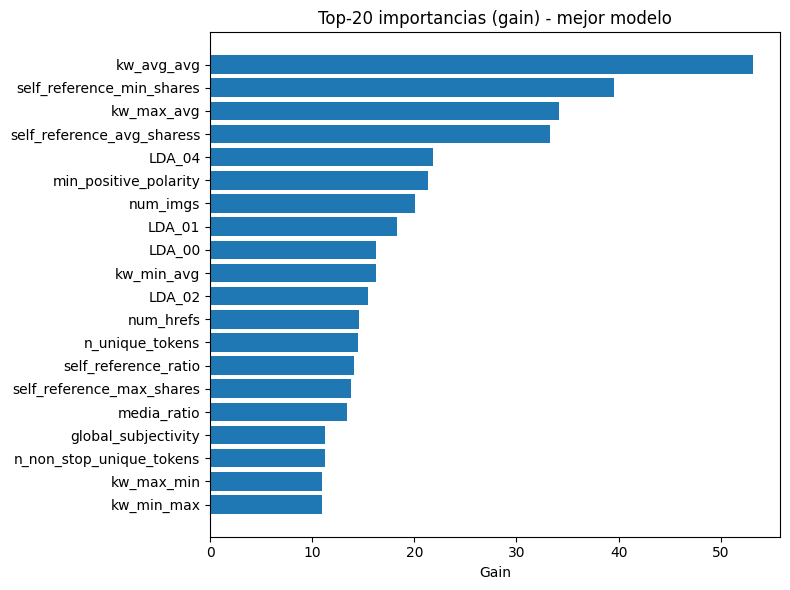

In [21]:
best_bst = models[0]
best_gain = best_bst.get_score(importance_type="gain")

imp_df = pd.DataFrame({
    "feature": list(best_gain.keys()),
    "gain": list(best_gain.values())
}).sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(imp_df["feature"], imp_df["gain"])
plt.gca().invert_yaxis()
plt.xlabel("Gain")
plt.title("Top-20 importancias (gain) - mejor modelo")
plt.tight_layout()
plt.show()

In [22]:
# Criterio: elige uno: "auc_test", "auc_valid", "f1_test"
# Esta variacion nos permite cambiar el enfoque del modelo para saber si modelo
# se va enfocar en distinguir o en clasificar.
# Recall no dejar escapar virales
# Equilibrio entre no detectar mucho y no aumentar los FP
# Si se quiere Rankear enfocarse en AUC


CRITERION = "auc_test"

best_row = results_df.sort_values(CRITERION, ascending=False).iloc[0]
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",  
    "seed": 42,
    "max_depth": int(best_row["max_depth"]),
    "min_child_weight": float(best_row["min_child_weight"]),
    "subsample": float(best_row["subsample"]),
    "colsample_bytree": float(best_row["colsample_bytree"]),
    "reg_lambda": float(best_row["reg_lambda"]),
    "learning_rate": float(best_row["learning_rate"]),
    "scale_pos_weight": float(base_params["scale_pos_weight"]),  # del train
}
best_rounds = int(best_row["best_iteration"])  # num_boost_round óptimo
best_thr   = float(best_row["thr_from_valid"]) # umbral aprendido en VALID
best_row


colsample_bytree                                                0.9
learning_rate                                                  0.08
max_depth                                                         4
min_child_weight                                                  1
reg_lambda                                                        7
subsample                                                       0.7
bst                 <xgboost.core.Booster object at 0x7451a1aee800>
auc_valid                                                   0.69371
auc_test                                                   0.647019
f1_test                                                    0.709413
thr_from_valid                                                0.265
best_iteration                                                  220
Name: 2, dtype: object

In [23]:
# Combinar train + valid
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
dtest       = xgb.DMatrix(X_test, label=y_test)

final_bst = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=best_rounds,
    evals=[(dtrain_full, "train_full")],
    verbose_eval=False
)

# Probabilidades en test (solo para reporte final)
proba_test_final = final_bst.predict(dtest)


Resultados finales

In [24]:
auc_test_final = roc_auc_score(y_test, proba_test_final)
y_pred_test_final = (proba_test_final >= best_thr).astype(int)

print(f"AUC_test(final): {auc_test_final:.3f}  | thr(use valid): {best_thr:.3f}")
print(classification_report(y_test, y_pred_test_final, digits=3))
print(confusion_matrix(y_test, y_pred_test_final))


AUC_test(final): 0.637  | thr(use valid): 0.265
              precision    recall  f1-score   support

           0      0.701     0.017     0.034      2695
           1      0.559     0.994     0.715      3371

    accuracy                          0.560      6066
   macro avg      0.630     0.506     0.375      6066
weighted avg      0.622     0.560     0.413      6066

[[  47 2648]
 [  20 3351]]


In [35]:
# Crear un diccionario con todo lo importante
model_package = {
    "model": final_bst,
    "params": best_params,
    "best_rounds": best_rounds,
    "threshold": best_thr,
    "criterion": CRITERION,
    "timestamp": datetime.now().isoformat(timespec="seconds")
}

current_dir = os.getcwd()

# Nombre del archivo del modelo
model_name = "01_xgb_CDC.pkl"

# Ruta completa (en la misma carpeta del notebook)
model_path = os.path.join(current_dir, model_name)

# Guardar el modelo
with open(model_path, "wb") as f:
    pickle.dump(model_package, f)

print(f"Modelo guardado en la misma carpeta del notebook: {model_path}")

Modelo guardado en la misma carpeta del notebook: /home/carlosdelcastillo/code/MLOps_Course_Project/notebooks/01_xgb_CDC.pkl
